# TME 3 - Régularisation L1


In [55]:
import numpy as np
from sklearn import datasets
from sklearn import metrics
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import functools
import operator
import itertools

%matplotlib inline

# Loading 'breast cancer' dataset, a simple dataset
cancer = datasets.load_breast_cancer()
X = cancer.data
y = cancer.target

X, y = shuffle(X, y)

# Decrease data to speed up computation
X = X[:50,:5]
y = y[:50]

print("shape of X:", X.shape)
print("shape of Y:", y.shape)
print("classes in Y: ", np.unique(y, return_counts=True))

shape of X: (569, 30)
shape of Y: (569,)
classes in Y:  (array([0, 1]), array([212, 357]))


In [46]:
from scipy.optimize import approx_fprime, check_grad, minimize


def decision(theta, X):
    """ The decision function that predicts a target
    :param theta: The parameter for the decision
    :param X: The data.
    
    theta.shape = (n,) and X.shape = (l, n)
    :return: a vector of predictions of shape (l,)"""
    return np.sign(X.dot(theta)) / 2 + 0.5

def loss(theta, X, y, pen):
    """ The loss function
    :param theta: The vector doing the decision
    :param X: The data
    :param y: The target values
    :param pen: The penalization parameter (The higher 'pen', the lower |theta|)
    :return: The loss for the given parameters.
    """
    mse = ((y - X.dot(theta))**2).mean()
    return mse + pen * sum([np.abs(t) for t in theta])

def gradient_loss(theta, X, y, pen):
    """ The gradient of the loss function
    :param theta: The vector doing the decision
    :param X: The data
    :param y: The target values
    :param pen: The penalization parameter
    :return: The gradient of the for the given parameters.
    """
    gradient = 2 * X.T.dot(X.dot(theta) - y) / X.shape[0] + pen * np.sign(theta)
    return gradient

### Testing if the gradient is correct ### 
print("Checking gradient with random theta:")
np.set_printoptions(precision=1, threshold=5)
for i in range(10):
    print("\n### Iteration %d ###" % i)
    theta = np.random.random(X[0].shape) - 0.5
    theta *= 10**np.random.randint(1, 8)
    pen = np.random.random() / 10
    func = lambda t:loss(t, X, y, pen)
    grad = lambda t:gradient_loss(t, X, y, pen)
    print("Theta :                               ", theta)
    print("Gradient according to approx_fprime():", approx_fprime(theta, func, epsilon=1))
    print("Gradient according to gradient_loss():", grad(theta))
    err = check_grad(func, grad, theta)
    print("Error according to check_grad(): %f (%f%%)" % (err, err / np.linalg.norm(grad(theta)) * 100))

Checking gradient with random theta:

### Iteration 0 ###
Theta :                                [-18473.8  15156.3 -47781.2 -30771.8 -33936.1]
Gradient according to approx_fprime(): [ -8.2e+08  -9.9e+08  -5.4e+09  -4.4e+10  -5.1e+06]
Gradient according to gradient_loss(): [ -8.2e+08  -9.9e+08  -5.4e+09  -4.4e+10  -5.1e+06]
Error according to check_grad(): 26056150.279580 (0.058964%)

### Iteration 1 ###
Theta :                                [ -48988.5  267634.1 -441940.7   77462.1  -18999.1]
Gradient according to approx_fprime(): [  5.8e+08   6.4e+08   3.8e+09   3.4e+10   3.2e+06]
Gradient according to gradient_loss(): [  5.8e+08   6.4e+08   3.8e+09   3.4e+10   3.2e+06]
Error according to check_grad(): 14935980.238496 (0.043685%)

### Iteration 2 ###
Theta :                                [ -7646.     973.8  24617.5  40277.2 -45218. ]
Gradient according to approx_fprime(): [  9.7e+08   1.2e+09   6.4e+09   5.2e+10   5.9e+06]
Gradient according to gradient_loss(): [  9.7e+08   1.2e+09 

###########  Step 0 : #################
========= i = 0, random idx = 3 ===========
Theta before:  [ 0.  0.  0.  0.  0.]
Gradient:      [  2.07e+02   3.63e+02   9.38e+03   5.98e+05  -9.93e-02]
Theta after:   [ -2.07e-01  -3.63e-01  -9.38e+00  -5.98e+02   9.93e-05]
========= i = 1, random idx = 48 ===========
Theta before:  [ -2.07e-01  -3.63e-01  -9.38e+00  -5.98e+02   9.93e-05]
Gradient:      [ -1.33e+07  -1.60e+07  -8.78e+07  -7.16e+08  -8.13e+04]
Theta after:   [  1.33e+04   1.60e+04   8.78e+04   7.16e+05   8.13e+01]
========= i = 2, random idx = 29 ===========
Theta before:  [  1.33e+04   1.60e+04   8.78e+04   7.16e+05   8.13e+01]
Gradient:      [  1.62e+10   1.94e+10   1.07e+11   8.70e+11   9.88e+07]
Theta after:   [ -1.62e+07  -1.94e+07  -1.07e+08  -8.69e+08  -9.87e+04]
========= i = 3, random idx = 5 ===========
Theta before:  [ -1.62e+07  -1.94e+07  -1.07e+08  -8.69e+08  -9.87e+04]
Gradient:      [ -1.97e+13  -2.36e+13  -1.30e+14  -1.06e+15  -1.20e+11]
Theta after:   [  1.97e+1

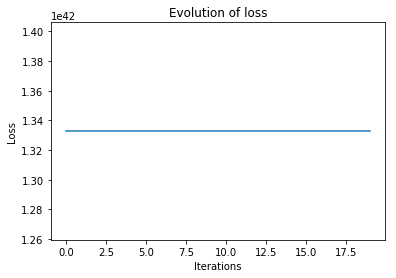

In [47]:
def gradient_desc(theta, X, y, max_iter=100, step=1e-1, verbose=0, plot=False, force=False):
    """ Performs gradient descent to find the best theta
    :param theta: The initial scalar for the search
    :param X: The data
    :param y: The target values
    :param max_iter: The number of iterations
    :param step: The scalar the will be multiplied to the gradient vector to increment theta
    :param verbose: The level of displayed information
    :param plot: Whether to plot the evolution of the loss
    :param force: Whether to deactivate the warning if too much output
    
    :return: The theta at the end of the gradient descent"""
    
    (l, n) = X.shape
    losses = []
    
    if not force and verbose > 1 and max_iter > 50:
        print("Warning, there will be a lot of output, it can freeze the kernel.")
        print("If you really want to proceed, relaunch with 'force=True'")
 
    loss_func = lambda t: loss(t, X, y, pen=0)
    
    for it in range(max_iter):
        if verbose >= 1:
            print("###########  Step", it, ": #################")
        if verbose >= 2:
            print("Theta before: ", theta)

        grad = gradient_loss(theta, X, y, pen=0)

        if verbose >= 2:
            print("Gradient:     ",grad)

        theta -= step * grad

        if verbose >= 2:
            print("Theta after:  ", theta)


        it_loss = loss(theta, X, y, pen=0)
        losses.append(it_loss)
        if verbose >= 1:
            print("Loss :     %f" % (it_loss))
            errors = np.count_nonzero(decision(theta, X) - y)
            print("Accuracy : %d/%d right guesses" % (l - errors, l))
                
    if plot:
        plt.plot(losses)
        plt.title("Evolution of loss")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        

# Optimization parameters
theta_init = np.zeros(X[0].shape)
max_iter = 20
step     = 1e-3

# Find theta 
np.set_printoptions(precision=2, threshold=5)
theta = gradient_descent(theta_init, X, y, max_iter=max_iter, step=step, verbose=2, plot=True)
   

###########  Step 0 : #################
========= i = 0, random idx = 24 ===========
Theta before:  [ 0.  0.  0.  0.  0.]
Gradient:      [  1.96e+02   3.68e+02   8.92e+03   5.95e+05  -1.16e-01]
Theta after:   [ -1.96e-01  -3.68e-01  -8.92e+00  -5.95e+02   1.16e-04]
========= i = 1, random idx = 35 ===========
Theta before:  [ -1.96e-01  -3.68e-01  -8.92e+00  -5.95e+02   1.16e-04]
Gradient:      [ -1.28e+07  -1.54e+07  -8.42e+07  -7.10e+08  -7.53e+04]
Theta after:   [  1.28e+04   1.54e+04   8.41e+04   7.09e+05   7.53e+01]
========= i = 2, random idx = 30 ===========
Theta before:  [  1.28e+04   1.54e+04   8.41e+04   7.09e+05   7.53e+01]
Gradient:      [  1.55e+10   1.86e+10   1.02e+11   8.58e+11   9.11e+07]
Theta after:   [ -1.55e+07  -1.86e+07  -1.02e+08  -8.57e+08  -9.10e+04]
========= i = 3, random idx = 21 ===========
Theta before:  [ -1.55e+07  -1.86e+07  -1.02e+08  -8.57e+08  -9.10e+04]
Gradient:      [ -1.87e+13  -2.25e+13  -1.23e+14  -1.04e+15  -1.10e+11]
Theta after:   [  1.87e

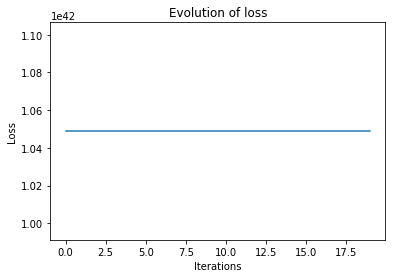

In [35]:
def gradient_stoch(theta, X, y, max_iter=100, step=1e-1, verbose=0, plot=False, force=False):
    """ Performs stochastic gradient descent to find the best theta
    :param theta: The initial scalar for the search
    :param X: The data
    :param y: The target values
    :param max_iter: The number of iterations
    :param step: The scalar the will be multiplied to the gradient vector to increment theta
    :param verbose: The level of displayed information
    :param plot: Whether to plot the evolution of the loss
    :param force: Whether to deactivate the warning if too much output
    
    :return: The theta at the end of the gradient descent"""
    
    (l, n) = X.shape
    losses = []
    
    if not force and verbose > 1 and max_iter > 50:
        print("Warning, there will be a lot of output, it can freeze the kernel.")
        print("If you really want to proceed, relaunch with 'force=True'")
 
    
    for it in range(max_iter):
        if verbose >= 1:
            print("###########  Step", it, ": #################")
        for i in range(l):
            idx = np.random.randint(0, l)
            
            if verbose >= 2:
                print("========= i = %d, random idx = %d ===========" % (i, idx))
                print("Theta before: ", theta)
            
            grad = gradient_loss(theta, np.array([X[idx]]), np.array([y[idx]]), pen=0)
            
            # If we don't trust the 'gradient_loss' function:
            local_loss = lambda t: loss(t, np.array([X[idx]]), np.array([y[idx]]), pen=0)
            grad = approx_fprime(theta, local_loss, epsilon=1)
            
            if verbose >= 2:
                print("Gradient:     ",grad)
#                 it_grad = lambda t: gradient_loss(theta, X, y, pen=0)
#                 print("debug: check_grad:", check_grad(loss_func, it_grad, theta))
                
            theta -= step * grad
            
            if verbose >= 2:
                print("Theta after:  ", theta)


        it_loss = loss(theta, X, y, pen=0)
        losses.append(it_loss)
        if verbose >= 1:
            print("Loss :     %f" % (it_loss))
            errors = np.count_nonzero(decision(theta, X) - y)
            print("Accuracy : %d/%d right guesses" % (l - errors, l))
                
    if plot:
        plt.plot(losses)
        plt.title("Evolution of loss")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        

# Optimization parameters
theta_init = np.zeros(X[0].shape)
max_iter = 20
step     = 1e-3

# Find theta 
np.set_printoptions(precision=2, threshold=5)
theta = gradient_descent(theta_init, X, y, max_iter=max_iter, step=step, verbose=2, plot=True)
   

###########  Step 0 : #################
========= i = 0, random idx = 49 ===========
debug: check_grad: 0.0211740425065
Gradient:      [ 0.  0.  0. ...,  0.  0.  0.]
Theta before:  [ 0.  0.  0. ...,  0.  0.  0.]
Theta after:   [ 0.  0.  0. ...,  0.  0.  0.]
========= i = 1, random idx = 48 ===========
debug: check_grad: 0.00162015475461
Gradient:      [ -2.09e+01  -3.09e+01  -1.33e+02 ...,  -2.43e-02  -3.58e-01  -1.29e-01]
Theta before:  [ 0.  0.  0. ...,  0.  0.  0.]
Theta after:   [  2.09e-02   3.09e-02   1.33e-01 ...,   2.43e-05   3.58e-04   1.29e-04]
========= i = 2, random idx = 80 ===========
debug: check_grad: 0.00315264363354
Gradient:      [  7.56e+03   1.24e+04   4.91e+04 ...,   1.34e+01   1.31e+02   4.26e+01]
Theta before:  [  2.09e-02   3.09e-02   1.33e-01 ...,   2.43e-05   3.58e-04   1.29e-04]
Theta after:   [ 0.  0.  0. ...,  0.  0.  0.]
========= i = 3, random idx = 74 ===========
debug: check_grad: 0.00253692526082
Gradient:      [ -2.33e+01  -3.67e+01  -1.50e+02 ...,  

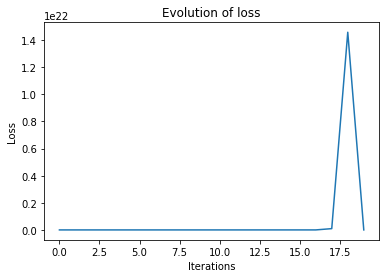

In [19]:
def gradient_l1(theta, X, y, max_iter=100, step=1e-1, pen=0.1, verbose=0, plot=False, force=False):
    """ Performs gradient clipping to find the best theta
    :param theta: The initial scalar for the search
    :param X: The data
    :param y: The target values
    :param max_iter: The number of iterations
    :param step: The scalar the will be multiplied to the gradient vector to increment theta
    :param pen: The regularization parameter
    :param verbose: The level of displayed information
    :param plot: Whether to plot the evolution of the loss
    :param force: Whether to deactivate the warning if too much output
    
    :return: The theta at the end of the gradient descent"""
    
    (l, n) = X.shape
    losses = []
    
    if not force and verbose > 1 and max_iter > 50:
        print("Warning, there will be a lot of output, it can freeze the kernel.")
        print("If you really want to proceed, relaunch with 'force=True'")
        return 
    
    for it in range(max_iter):
        if verbose >= 1:
            print("###########  Step", it, ": #################")
        for i in range(l):
            # Sample a random point 
            idx = np.random.randint(0, l)
            if verbose >= 2:
                print("========= i = %d, random idx = %d ===========" % (i, idx))
            # Compute the gradient on this single random point:
            local_loss = lambda t: loss(t, np.array([X[idx]]), np.array([y[idx]]), pen)
#             grad = approx_fprime(theta, local_loss, epsilon=step)
            
            grad = gradient_loss(theta, np.array([X[idx]]), np.array([y[idx]]), pen)
            
            #debug
            if verbose >=2:
                local_grad = lambda t: gradient_loss(theta, np.array([X[idx]]), np.array([y[idx]]), pen)
                print("debug: check_grad:", check_grad(local_loss, local_grad, theta))
                
            if verbose >= 2:
                print("Gradient:     ",grad)
                print("Theta before: ", theta)
                
            theta_prime = theta - step * grad
            theta_prime[theta * theta_prime < 0] = 0
            theta = theta_prime
            
            if verbose >= 2:
                print("Theta after:  ", theta)
                
        general_loss = loss(theta, X, y, pen)
        losses.append(general_loss)
        if verbose >= 1:
            print("Loss :     %f" % (general_loss))
            errors = np.count_nonzero(decision(theta, X) - y)
            print("Accuracy : %d/%d right guesses" % (l - errors, l))
    
    if plot:
        plt.plot(losses)
        plt.title("Evolution of loss")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        
    return theta

# Optimization parameters
theta_init = np.zeros(X[0].shape)
max_iter = 20
step     = 1e-3
pen      = 0

# Find theta 
np.set_printoptions(precision=2, threshold=5)
theta = gradient_l1(theta_init, X, y, max_iter=max_iter, pen=pen, step=step, verbose=2, plot=True)
theta_minimize = minimize(lambda t:loss(t, X, y, pen), theta_init).x
print("theta with gradient_l1():", theta)
print("theta with minimize()   :", theta_minimize)



In [58]:
from sklearn.base import BaseEstimator

class LinearClassifier(BaseEstimator):
    """ Custom linear classifier """
    
    def __init__(self, max_iter=1000, step=1e-2, pen=1e-2, verbose=0):
        self.theta= 0
        self.max_iter = max_iter
        self.step = step
        self.pen = pen
        self.verbose = verbose
    
    def fit(self, X, y):
        self.theta = minimize(lambda t: loss(t, X, y, pen=self.pen), 
                              np.zeros_like(X[0])).x
        
        # If gradient_l1() works:
#         self.theta = gradient_l1(np.ones_like(X[0]), X, y, 
#                                  max_iter=self.max_iter, 
#                                  step=self.step, 
#                                  pen=self.pen,
#                                  verbose=self.verbose)
        
    def predict(self, X):
        return decision(self.theta, X)

    def get_theta(self):
        return self.theta

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import KFold


print("Evaluating with cross validation")
kf = KFold(n_splits=4)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = y[train_index], y[test_index]
    clf = LinearClassifier(max_iter=20, step=step, pen=0, verbose=2)
    clf.fit(X_train, Y_train)
    pred = clf.predict(X_test)
    print(20 * '-')
    print("Y_Pred: ", pred)
    print("Y_reel: ", Y_test)
    print("Score: ", accuracy_score(pred, Y_test))
    print("Errors on following labels: ", Y_test[pred != Y_test])


Evaluating with cross validation
--------------------
Y_Pred:  [ 1.  1.  1. ...,  0.  1.  1.]
Y_reel:  [1 0 1 ..., 0 0 1]
Score:  0.804195804196
Errors on following labels:  [0 0 0 ..., 0 0 0]
--------------------
Y_Pred:  [ 1.  1.  1. ...,  1.  1.  1.]
Y_reel:  [1 1 1 ..., 1 1 0]
Score:  0.746478873239
Errors on following labels:  [0 0 0 ..., 0 0 0]
--------------------
Y_Pred:  [ 1.  1.  1. ...,  1.  1.  0.]
Y_reel:  [1 1 1 ..., 0 1 0]
Score:  0.711267605634
Errors on following labels:  [0 0 0 ..., 0 0 0]
--------------------
Y_Pred:  [ 1.  1.  1. ...,  1.  0.  1.]
Y_reel:  [0 1 1 ..., 0 0 0]
Score:  0.732394366197
Errors on following labels:  [0 0 0 ..., 0 0 0]


# Q4) Performance en fonction de la parcimonie du modèle

**Performance** : pourcentage de bonne classification sur un ensemble de test

**Parcimonie** : Le nombre d'éléments différents de 0, divisé par le nombre total d'éléments.

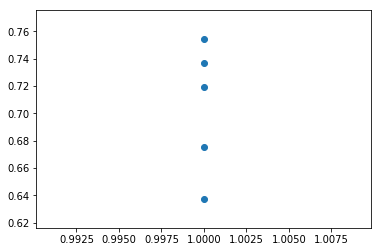

In [70]:
def sparsity(vect):
    return np.count_nonzero(vect)/len(vect)

scores = []
spars = []
kf = KFold(n_splits=5)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = y[train_index], y[test_index]
    clf = LinearClassifier(max_iter=20, step=step, pen=1e-1, verbose=2)
    clf.fit(X_train, Y_train)
    pred = clf.predict(X_test)
    scores.append(accuracy_score(pred, Y_test))
    spars.append(sparsity(clf.get_theta()))
    
plt.scatter(spars, scores);


Apparemment, aucun des vecteurs n'a de composante nulle...